# ![](https://github.com/alitoxSB/FootballAnalytics_HandBook/blob/main/data%20science%20in%20football.png?raw=true)

En este notebook se desarrollarán diferentes análisis con Python orientados a obtener información valiosa para la toma de decisiones en la gestión y dirección de equipos de fútbol. 

- Author: Justin Alejandro Zamora Esquivel
- Project: https://github.com/alitoxSB/FootballAnalytics_HandBook

Capítulo I: Aspectos importantes.
En una primera instancia, es importante mostrar cuáles son los aspectos importantes en la gestión del fútbol y las variables que definen el resultado de un partido.

*   Pases.
*   Pases filtrados.
*   Ubicación de los pases y su dirección inicial y final.
*   Remates al arco.
*   Localización del balón.
*   Traking de goles.
*   Métricas e indicadores de jugadores.


## Pases: ¿Cómo analizar los pases?
### ¿Qué dataframe usamos para realizar análisis de pases?
El conjunto de datos es el resultado de pases de messi en el partido FC Barcelona vs Real Betis.

In [10]:
!pip install mplsoccer

In [21]:
!pip install numpy

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import seaborn as sns
import numpy as np

In [36]:
df = pd.read_csv("messibetis.csv")

In [37]:
#convert the data to match the mplsoccer statsbomb pitch
#to see how to create the pitch, watch the video here: https://www.youtube.com/watch?v=55k1mCRyd2k
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Passes from Lionel Messi')

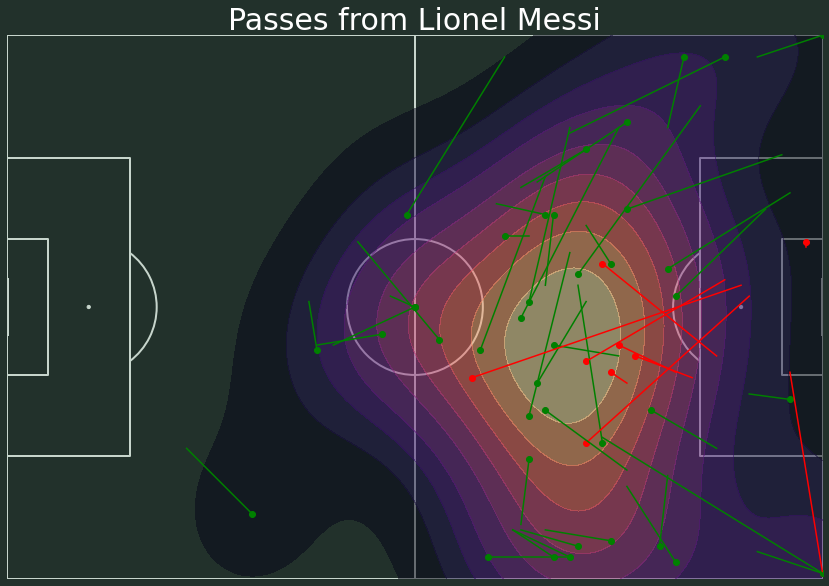

In [39]:
fig ,ax = plt.subplots(figsize=(20,10))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

#this is how we create the pitch
pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#22312b', line_color='#c7d5cc', figsize=(13, 8),
              constrained_layout=False, tight_layout=True)

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)
plt.gca().invert_yaxis()

#Create the heatmap
kde = sns.kdeplot(
        df['x'],
        df['y'],
        shade = True,
        shade_lowest=False,
        alpha=.5,
        n_levels=10,
        cmap = 'magma'
)


#use a for loop to plot each pass
for x in range(len(df['x'])):
    if df['outcome'][x] == 'Successful':
        plt.plot((df['x'][x],df['endX'][x]),(df['y'][x],df['endY'][x]),color='green')
        plt.scatter(df['x'][x],df['y'][x],color='green')
    if df['outcome'][x] == 'Unsuccessful':
        plt.plot((df['x'][x],df['endX'][x]),(df['y'][x],df['endY'][x]),color='red')
        plt.scatter(df['x'][x],df['y'][x],color='red')
        
plt.xlim(0,120)
plt.ylim(0,80)

plt.title('Passes from Lionel Messi',color='white',size=30)

## ¿Podemos estudiar la dificultad de un equipo o jugador para dar un pase?.
### Si, con la ayuda de Redes neuronales
Este trabajo está muy motivado por el reciente artículo SoccerMap publicado por Javier Fernández y Luke Bornn, que proporcionó una arquitectura de aprendizaje profundo para producir superficies de probabilidad a partir de datos de seguimiento sin procesar. Es realmente brillante y deberías echarle un vistazo. Este cuaderno es un ejercicio para aplicar algunos de los principales aprendizajes de su artículo, en particular la evaluación de una función de pérdida en un solo píxel de salida, al dominio menos exclusivo basado en eventos.
Usando los datos abiertos de StatsBomb de la Copa del Mundo de 2018, nuestro objetivo es producir superficies de probabilidad de completar pases continuos dada la ubicación de origen del pase. Naturalmente, nuestras predicciones ofrecen menos flexibilidad y precisión que las producidas con el contexto más rico que se encuentra en los datos de seguimiento completo, pero creo que esto ofrece una posible mejora en muchos modelos de probabilidad de pase existentes en el dominio basado en eventos. Y produce algunas parcelas realmente atractivas en el camino.

In [41]:
!pip install git+https://github.com/devinpleuler/analytics-handbook.git

  Cloning https://github.com/devinpleuler/analytics-handbook.git to c:\users\justi\appdata\local\temp\pip-req-build-6nx9hjo6


  Running command git clone -q https://github.com/devinpleuler/analytics-handbook.git 'C:\Users\justi\AppData\Local\Temp\pip-req-build-6nx9hjo6'


In [43]:
from soccerutils.statsbomb import get_events
from soccerutils.pitch import Pitch

In [45]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

Obteniendo todos los eventos de la Copa del Mundo 2018 y colócalos en la lista de eventos.

In [47]:
events = get_events(competition_id=43, season_id=3)

Usamos transform () y build_tensor () para ayudar a construir nuestros datos de entrenamiento. Puede ver los resultados de estas funciones en forma espacial un poco más abajo en el cuaderno.

Recomiendo encarecidamente utilizar numerosos enfoques vectorizados para la construcción de estas superficies, de lo contrario, estará sentado un rato esperando a que se completen los datos de entrenamiento.

Nota: tomamos prestadas algunas de las dimensiones de la matriz de SoccerMap, trabajando a 1/2 y 1/4 de tamaño de su representación de 104 x 68.

In [49]:
def transform(coords, x_bins=52, y_bins=34):
    x, y = coords
    
    x_bin = np.digitize(x, np.linspace(0, 120, x_bins))
    y_bin = np.digitize(y, np.linspace(0, 80, y_bins))
  
    matrix = np.zeros((x_bins, y_bins))
    try:
        matrix[x_bin][y_bin] = 1
    except IndexError:
        pass
    
    return matrix

def build_tensor(point, x_bins=52, y_bins=34):    
    xx = np.linspace(0, 120, x_bins)
    yy = np.linspace(0, 80, y_bins)
    xv, yv = np.meshgrid(xx, yy, sparse=False, indexing='ij')
    coords = np.dstack([xv, yv])
    
    origin = np.array(point)
    goal = np.array([120,40])
    
    pos = transform(point)
    r_origin = np.linalg.norm(origin - coords, axis=2)
    r_goal = np.linalg.norm(goal - coords, axis=2)
    
    tensor = np.dstack([pos, r_origin, r_goal])
            
    return tensor

In [51]:
from tqdm import tqdm

In [53]:
passes= []
for e in tqdm(events):
    if e['type']['id'] == 30: # Events with type ID == 30 are Passes
        passes.append({
            'player': e['player'],
            'origin': build_tensor(e['location']),
            'dest': transform(e['pass']['end_location']),
            'outcome': 0 if 'outcome' in e['pass'].keys() else 1
        })

100%|██████████| 227886/227886 [00:33<00:00, 6713.05it/s]


In [55]:
Xp = np.asarray([p['origin'] for p in passes])
Xd = np.asarray([p['dest'] for p in passes])
Y = np.asarray([p['outcome'] for p in passes], dtype=np.float32)

In [59]:
from sklearn.model_selection import train_test_split

In [61]:
Xp_train, Xp_test, \
Xd_train, Xd_test, \
Y_train, Y_test = train_test_split(Xp, Xd, Y,
                                   test_size=0.1,
                                   random_state = 1,
                                   shuffle=True)

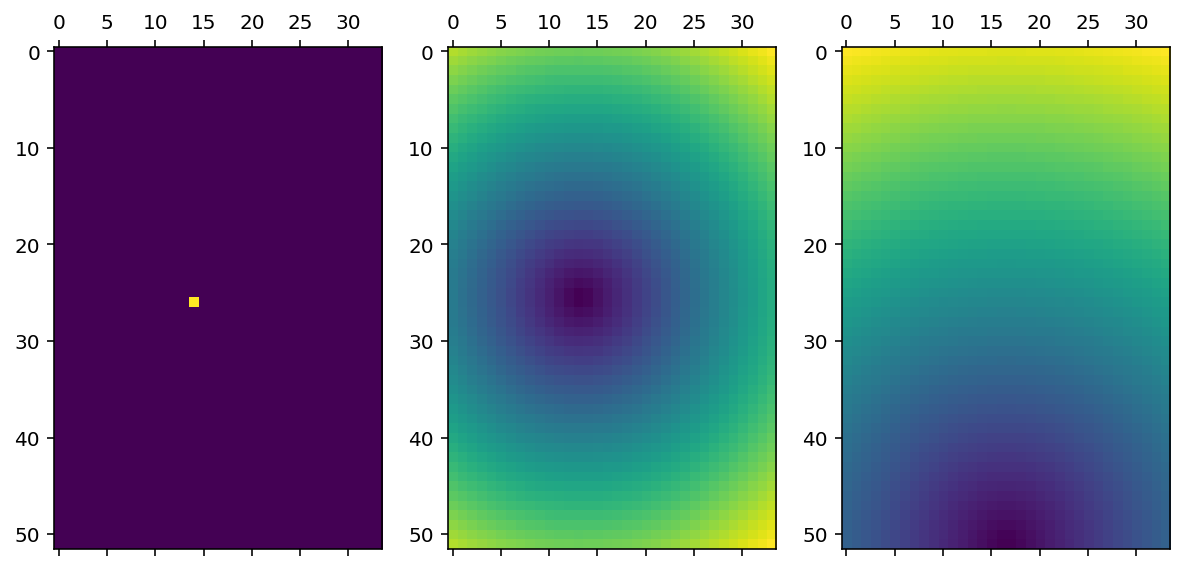

In [63]:
n = 500 # We use this sample index through the entire notebook
fig, axs = plt.subplots(1,3, figsize=(10,8))
for i, ax in enumerate(axs):
    ax.matshow(Xp_test[n][:,:,i])

In [67]:
avg_completion_rate = np.mean(Y_train)
print(avg_completion_rate)

0.79770994


In [71]:
!pip install keras

In [80]:
!pip install tensorflow

In [82]:
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras.initializers import Constant
import keras.backend as K

In [84]:
from tensorflow import pad, constant
# No pude averiguar cómo hacer padding con el backend de Keras

def symmetric_pad(x):
    paddings = constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    return pad(x, paddings, "SYMMETRIC")

Obtener el relleno correcto es fundamental para reducir los artefactos a lo largo de los bordes de nuestras superficies probables. Como las convoluciones reducen el tamaño de sus representaciones (dependiendo de su tamaño kernal y zancada), debe devolver sus representaciones al tamaño original.

El relleno simétrico es particularmente útil para esta situación, ya que llena las celdas de relleno con valores que son similares a los que lo rodean, a diferencia del mismo relleno que llena esas celdas con un valor constante.

Aplicamos este tipo de relleno después de cualquier capa de convolución que tenga tamaños de kernel distintos de (1,1).

In [86]:
def pixel_layer(x):
    surface = x[:,:,:,0]
    mask = x[:,:,:,1]
    masked = surface * mask
    value = K.sum(masked, axis=(2,1))    
    return value

Esta capa personalizada de un solo píxel es una pieza fundamental para evaluar la pérdida durante el entrenamiento del modelo.

Como puede ver en la estructura del modelo a continuación, pasamos dos entradas separadas. Uno son los datos de entrenamiento que construimos a través de build_tensor (), pero también pasamos la representación espacial dispersa del destino como una entrada separada.

Tomamos prestada esa capa para enmascarar (mediante la multiplicación) la superficie de predicción final de modo que podamos tomar la predicción en la celda de la superficie que coincide con el destino real del pase y compararlo con el valor real con pérdida de registro.

In [88]:
pass_input = Input(shape=(52,34,3), name='pass_input')
dest_input = Input(shape=(52,34,1), name='dest_input')

x = Conv2D(16, (3, 3), activation='relu', padding='valid')(pass_input)
x = Lambda(symmetric_pad)(x)
x = Conv2D(1, (1, 1), activation='linear')(x)

x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = Lambda(symmetric_pad)(x)
x = Conv2D(1, (1, 1), activation='linear')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='valid')(x)
x = Lambda(symmetric_pad)(x)
out = Conv2D(1, (1,1), activation='sigmoid',
             kernel_initializer=Constant(avg_completion_rate))(x)

combined = Concatenate()([out, dest_input])
pixel = Lambda(pixel_layer)(combined)

model = Model([pass_input, dest_input], combined)
full = Model([pass_input, dest_input], pixel)

Observe que definimos dos modelos separados, modelo y completo. Uno es el subconjunto del otro.

Usaremos el modelo para producir superficies, mientras que usamos completo para producir predicciones solo en las coordenadas de destino de la pasada.

In [90]:
full.compile(loss="binary_crossentropy", optimizer="adam")

In [92]:
fit = full.fit(
    [Xp_train, Xd_train], Y_train,
    epochs=30,
    validation_data=([Xp_test, Xd_test], Y_test))

Epoch 1/30
1769/1769 [==============================] - 72s 41ms/step - loss: 0.3800 - val_loss: 0.3779
Epoch 2/30
1769/1769 [==============================] - 71s 40ms/step - loss: 0.3790 - val_loss: 0.3743
Epoch 3/30
1769/1769 [==============================] - 71s 40ms/step - loss: 0.3784 - val_loss: 0.3895
Epoch 4/30
1769/1769 [==============================] - 70s 40ms/step - loss: 0.3790 - val_loss: 0.3794
Epoch 5/30
1769/1769 [==============================] - 72s 41ms/step - loss: 0.3793 - val_loss: 0.3745
Epoch 6/30
1769/1769 [==============================] - 72s 41ms/step - loss: 0.3775 - val_loss: 0.3839
Epoch 7/30
1769/1769 [==============================] - 70s 40ms/step - loss: 0.3787 - val_loss: 0.3757
Epoch 8/30
1769/1769 [==============================] - 71s 40ms/step - loss: 0.3779 - val_loss: 0.3759
Epoch 9/30
1769/1769 [==============================] - 76s 43ms/step - loss: 0.3778 - val_loss: 0.3788
Epoch 10/30
1769/1769 [==============================] - 76s 43m

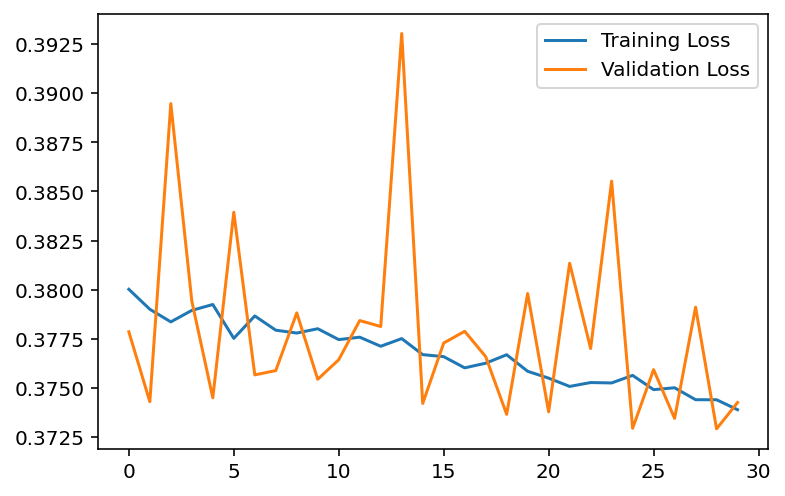

In [94]:
train_loss = fit.history['loss']
test_loss = fit.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label="Validation Loss")
plt.legend(loc='best')
plt.show()

In [96]:
surfaces = model.predict([Xp_test, Xd_test])

Construimos superficies a partir de los datos de prueba

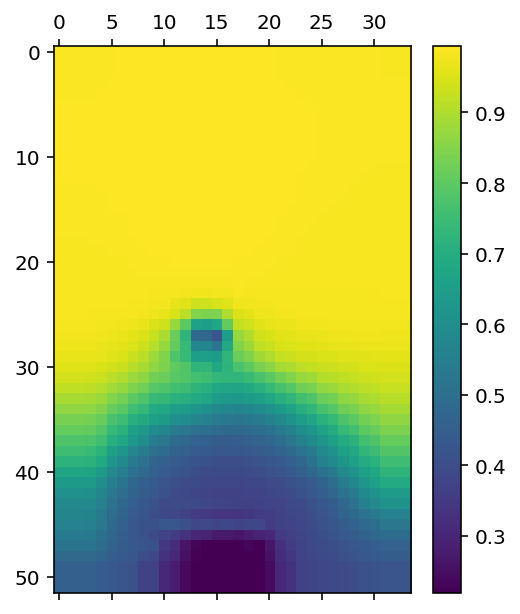

In [98]:
s = plt.matshow(surfaces[n][:,:,0])
plt.colorbar(s, shrink=0.8)

Observe los hoyuelos en el paso difícil alrededor del origen del paso. Esto se debe al sesgo de supervivencia causado por la eliminación de pases incompletos antes de que lleguen a su destino previsto. En particular, esto ocurre con frecuencia con pasajes bloqueados cerca del origen, lo que provoca este interesante artefacto. En un mundo ideal, estaríamos usando el destino previsto del pase en lugar del destino de la acción, pero eso es imposible en el dominio basado en eventos.

In [100]:
from scipy.ndimage import gaussian_filter

In [103]:
def draw_map(img, pass_, title=None, dims=(52,34)):
    image = gaussian_filter((img).reshape(dims), sigma=1.8)
    fig, ax = plt.subplots(figsize=(8,6))

    pitch = Pitch(title=title)
    pitch.create_pitch(ax)

    z = np.rot90(image, 1)

    xx = np.linspace(0, 120, 52)
    yy = np.linspace(0, 80, 34)

    c = ax.contourf(
        xx, yy, z,
        zorder=2,
        levels=np.linspace(0.2, 1.0, 17),
        alpha=0.8,
        antialiased=True,
        cmap='RdBu')

    x,y = np.unravel_index(pass_.argmax(), pass_.shape)
    y = dims[1] - y
    origin = np.asarray([x,y])*[120/dims[0],80/dims[1]]

    cosmetics = {
        'linewidth': 1,
        'facecolor': "yellow",
        'edgecolor': "black",
        'radius': 1.5,
        'zorder': 5
    }

    pitch.draw_points(ax, [origin], cosmetics=cosmetics)

    ax.set_aspect(1)
    ax.axis('off')

    plt.tight_layout()
    plt.colorbar(c, ax=ax, shrink=0.6)
    plt.show()

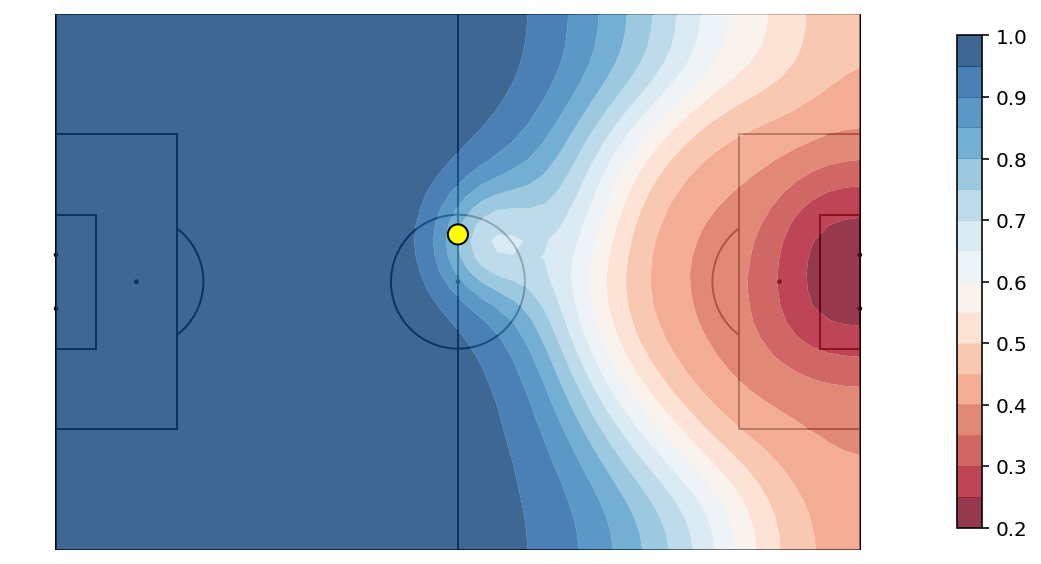

In [104]:
surface = surfaces[n][:,:,0]
draw_map(surface, Xp_test[n][:,:,0])